In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

## masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
         0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
         0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
         1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
         0.33863009])
## total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses) #=59.9
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33

## UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
## projected separation divided by effective radius from Georgiev
UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667, 
                                  0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
                                  1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
                                  0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
                                  1.22266667])

UGC8638_rperps_norms =  np.array([])

NGC4605_rperps_norms =  np.array([])
## physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
#UGC8638_rperps = UGC7369_rperps_norms*UGC7369_R_e
#NGC4605_rperps = UGC7369_rperps_norms*UGC7369_R_e

## a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

ModuleNotFoundError: No module named 'numba'

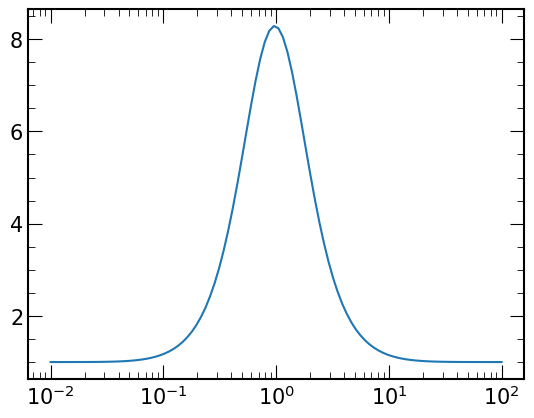

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-3-bfd7459ae38d>:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
8.542487621307373
3.5 0.1
finished until t = 0.0 0.9592912197113037


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 5.1508965492248535
finished until t = 1.0 12.342867612838745
finished until t = 1.5 22.020771503448486
finished until t = 2.0 32.883564472198486
finished until t = 2.5 46.3115770816803
finished until t = 3.0 62.34837555885315
finished until t = 3.5 79.63748955726624
finished until t = 4.0 98.73120355606079
finished until t = 4.5 120.10195326805115
finished until t = 5.0 143.67464423179626
finished until t = 5.5 171.37622737884521
finished until t = 6.0 200.68454766273499
finished until t = 6.5 231.95482540130615
finished until t = 7.0 264.58326530456543
finished until t = 7.5 302.723265171051
finished until t = 8.0 343.6535875797272
finished until t = 8.5 385.9691631793976
finished until t = 9.0 430.5523946285248
finished until t = 9.5 477.26697993278503
finished until t = 10.0 523.188206911087


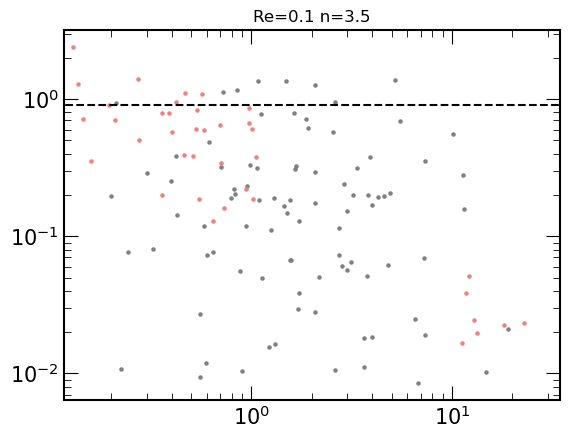

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.459714412689209
3.5 0.6
finished until t = 0.0 0.5620405673980713
finished until t = 0.5 4.366257905960083
finished until t = 1.0 11.514436721801758
finished until t = 1.5 22.05677604675293
finished until t = 2.0 36.13372492790222
finished until t = 2.5 54.25526165962219
finished until t = 3.0 76.6042811870575
finished until t = 3.5 103.12206220626831
finished until t = 4.0 133.21517753601074
finished until t = 4.5 166.96803784370422
finished until t = 5.0 204.71099758148193
finished until t = 5.5 245.3485872745514
finished until t = 6.0 289.5637094974518
finished until t = 6.5 337.01064467430115
finished until t = 7.0 387.99985456466675
finished until t = 7.5 445.93154883384705
finished until t = 8.0 514.9930510520935
finished until t = 8.5 589.4410390853882
finished until t = 9.0 667.5484535694122
finished until t = 9.5 750.3211185932159
finished until t = 10.0 836.9986708164215


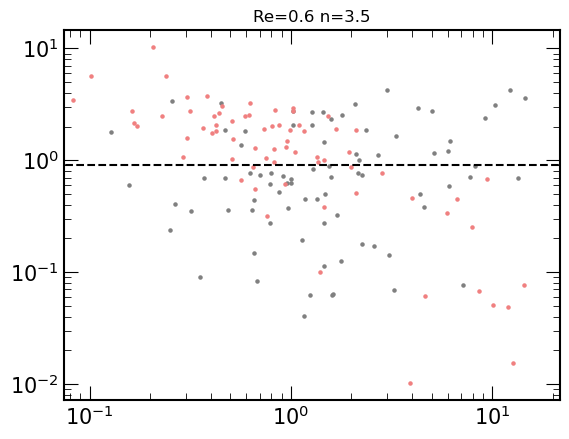

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.781144857406616
3.5 1.1
finished until t = 0.0 0.8816897869110107
finished until t = 0.5 6.291332721710205
finished until t = 1.0 16.516433000564575
finished until t = 1.5 31.506139993667603
finished until t = 2.0 50.99155259132385
finished until t = 2.5 75.5159330368042
finished until t = 3.0 105.2066855430603
finished until t = 3.5 140.08879899978638
finished until t = 4.0 179.89577770233154
finished until t = 4.5 225.508455991745
finished until t = 5.0 275.8070435523987
finished until t = 5.5 330.58796739578247
finished until t = 6.0 390.7121045589447
finished until t = 6.5 456.07890796661377
finished until t = 7.0 526.3104615211487
finished until t = 7.5 601.9732365608215
finished until t = 8.0 682.9181869029999
finished until t = 8.5 769.0101640224457
finished until t = 9.0 860.4194428920746
finished until t = 9.5 956.476181268692
finished until t = 10.0 1057.829654932022


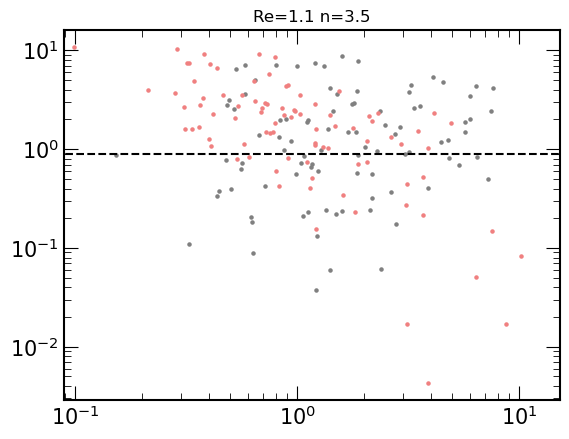

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.44063425064087
3.5 1.6
finished until t = 0.0 0.7731759548187256
finished until t = 0.5 5.88670539855957
finished until t = 1.0 14.965624809265137
finished until t = 1.5 28.29722809791565
finished until t = 2.0 45.41151833534241
finished until t = 2.5 67.25872826576233
finished until t = 3.0 92.74692559242249
finished until t = 3.5 122.1902801990509
finished until t = 4.0 155.5884404182434
finished until t = 4.5 193.29027843475342
finished until t = 5.0 234.68714213371277
finished until t = 5.5 280.79414653778076
finished until t = 6.0 330.9013760089874
finished until t = 6.5 385.3566858768463
finished until t = 7.0 443.9578528404236
finished until t = 7.5 506.7948703765869
finished until t = 8.0 574.5100665092468
finished until t = 8.5 646.0688564777374
finished until t = 9.0 722.1686697006226
finished until t = 9.5 803.4903481006622
finished until t = 10.0 889.6725761890411


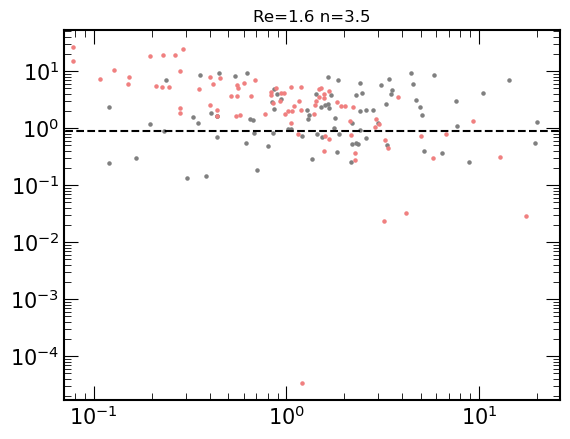

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.618921279907227
3.5 2.1
finished until t = 0.0 0.7792179584503174
finished until t = 0.5 6.114917516708374
finished until t = 1.0 16.312309741973877
finished until t = 1.5 30.568851232528687
finished until t = 2.0 49.81396460533142
finished until t = 2.5 74.19912028312683
finished until t = 3.0 103.2136082649231
finished until t = 3.5 137.2905035018921
finished until t = 4.0 176.57405734062195
finished until t = 4.5 220.39891624450684
finished until t = 5.0 269.27782559394836
finished until t = 5.5 323.20602345466614
finished until t = 6.0 382.22074365615845
finished until t = 6.5 446.1116235256195
finished until t = 7.0 515.5924289226532
finished until t = 7.5 590.0100674629211
finished until t = 8.0 669.2808606624603
finished until t = 8.5 753.2015595436096
finished until t = 9.0 842.1784405708313
finished until t = 9.5 935.6271934509277
finished until t = 10.0 1033.9116451740265


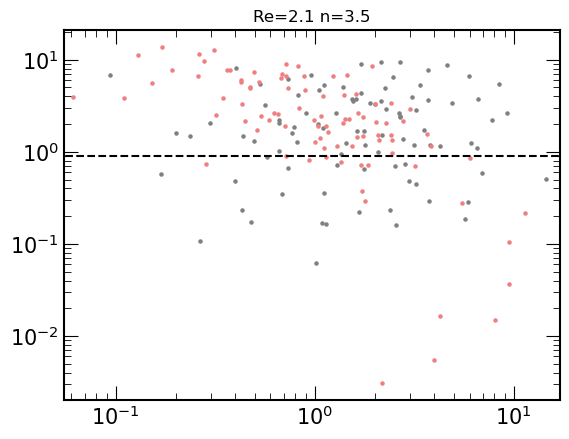

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.422792911529541
3.5 2.6
finished until t = 0.0 0.7716922760009766
finished until t = 0.5 6.275786399841309
finished until t = 1.0 15.997833013534546
finished until t = 1.5 29.878095388412476
finished until t = 2.0 48.90118336677551
finished until t = 2.5 72.46723532676697
finished until t = 3.0 101.2008695602417
finished until t = 3.5 134.77023243904114
finished until t = 4.0 173.25484037399292
finished until t = 4.5 216.20000839233398
finished until t = 5.0 263.6914987564087
finished until t = 5.5 315.57398867607117
finished until t = 6.0 372.503999710083
finished until t = 6.5 433.9796438217163
finished until t = 7.0 499.85861706733704
finished until t = 7.5 570.5616326332092
finished until t = 8.0 645.0709981918335
finished until t = 8.5 724.0780944824219
finished until t = 9.0 806.7100024223328
finished until t = 9.5 894.4706547260284
finished until t = 10.0 986.6985886096954


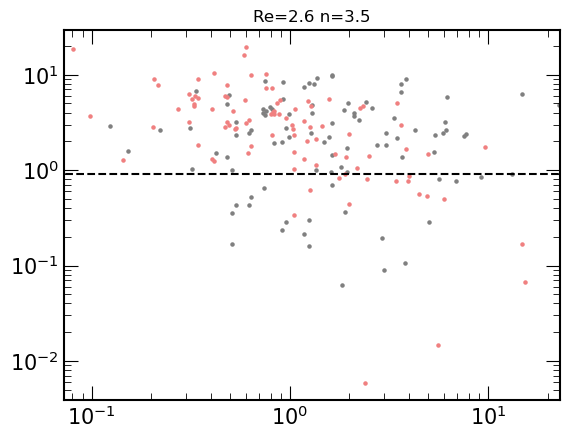

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.676025390625
3.5 3.1
finished until t = 0.0 0.7252407073974609
finished until t = 0.5 5.9115636348724365
finished until t = 1.0 14.438269138336182
finished until t = 1.5 27.61388611793518
finished until t = 2.0 44.71245622634888
finished until t = 2.5 66.21333503723145
finished until t = 3.0 91.41439652442932
finished until t = 3.5 121.3362979888916
finished until t = 4.0 155.19158458709717
finished until t = 4.5 193.0934352874756
finished until t = 5.0 234.6449327468872
finished until t = 5.5 280.6235511302948
finished until t = 6.0 331.0257112979889
finished until t = 6.5 386.0377540588379
finished until t = 7.0 445.03178215026855
finished until t = 7.5 508.4882073402405
finished until t = 8.0 575.9371755123138
finished until t = 8.5 647.4947745800018
finished until t = 9.0 723.4390342235565
finished until t = 9.5 803.5197699069977
finished until t = 10.0 887.1957387924194


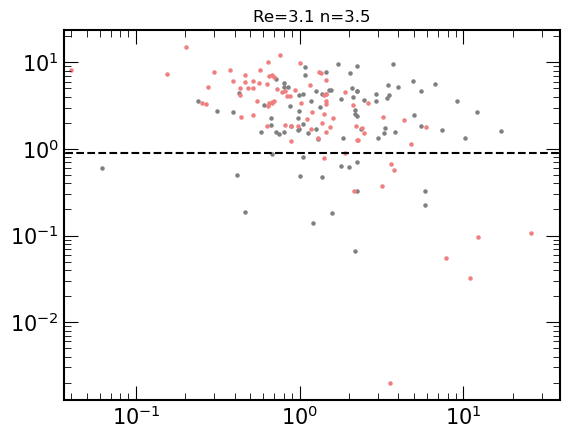

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.706971406936646
3.5 3.6
finished until t = 0.0 0.9040226936340332
finished until t = 0.5 6.534331321716309
finished until t = 1.0 17.020967721939087
finished until t = 1.5 32.324254274368286
finished until t = 2.0 52.60889983177185
finished until t = 2.5 77.78298759460449
finished until t = 3.0 105.51542949676514
finished until t = 3.5 137.3903613090515
finished until t = 4.0 173.60165977478027
finished until t = 4.5 215.09310913085938
finished until t = 5.0 260.925475358963
finished until t = 5.5 311.6232080459595
finished until t = 6.0 366.53919434547424
finished until t = 6.5 425.328675031662
finished until t = 7.0 488.97957468032837
finished until t = 7.5 556.8912937641144
finished until t = 8.0 629.2268903255463
finished until t = 8.5 706.2146406173706
finished until t = 9.0 787.6376943588257
finished until t = 9.5 873.4225406646729
finished until t = 10.0 963.6081624031067


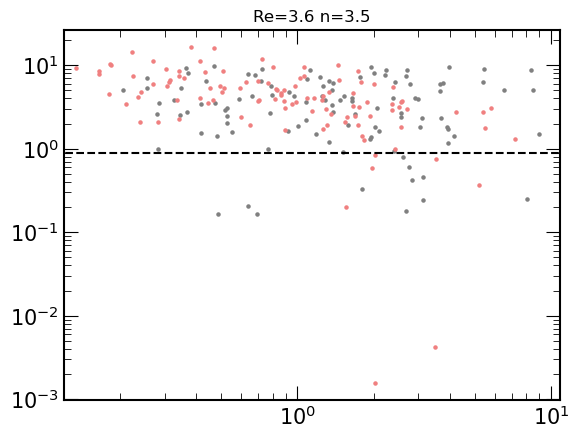

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.186817646026611
3.5 4.1
finished until t = 0.0 0.7008094787597656
finished until t = 0.5 5.197914361953735
finished until t = 1.0 13.912348508834839
finished until t = 1.5 26.3350932598114
finished until t = 2.0 42.500738859176636
finished until t = 2.5 60.921772480010986
finished until t = 3.0 82.87786388397217
finished until t = 3.5 108.07565665245056
finished until t = 4.0 136.98030543327332
finished until t = 4.5 169.37439894676208
finished until t = 5.0 205.57794499397278
finished until t = 5.5 245.0875940322876
finished until t = 6.0 288.87487387657166
finished until t = 6.5 335.5295009613037
finished until t = 7.0 385.69370770454407
finished until t = 7.5 439.67325353622437
finished until t = 8.0 497.11225986480713
finished until t = 8.5 555.9942679405212
finished until t = 9.0 617.19659948349
finished until t = 9.5 681.8021132946014
finished until t = 10.0 749.9150636196136


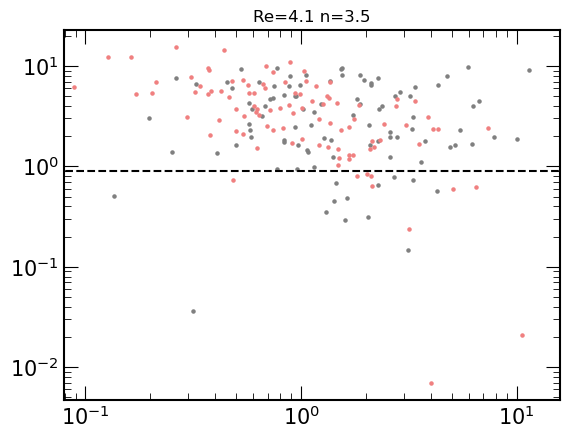

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
7.093853950500488
3.5 4.6
finished until t = 0.0 0.6677875518798828
finished until t = 0.5 5.106800556182861
finished until t = 1.0 13.397141933441162
finished until t = 1.5 25.503836393356323
finished until t = 2.0 41.45030236244202
finished until t = 2.5 61.21008229255676
finished until t = 3.0 84.95034766197205
finished until t = 3.5 112.56558322906494
finished until t = 4.0 144.18746852874756
finished until t = 4.5 179.0743715763092
finished until t = 5.0 213.48103761672974
finished until t = 5.5 251.54686188697815
finished until t = 6.0 292.850305557251
finished until t = 6.5 338.37966561317444
finished until t = 7.0 387.55332946777344
finished until t = 7.5 440.213006734848
finished until t = 8.0 496.1250796318054
finished until t = 8.5 555.4063608646393
finished until t = 9.0 618.2762877941132
finished until t = 9.5 684.3626098632812
finished until t = 10.0 755.1665976047516


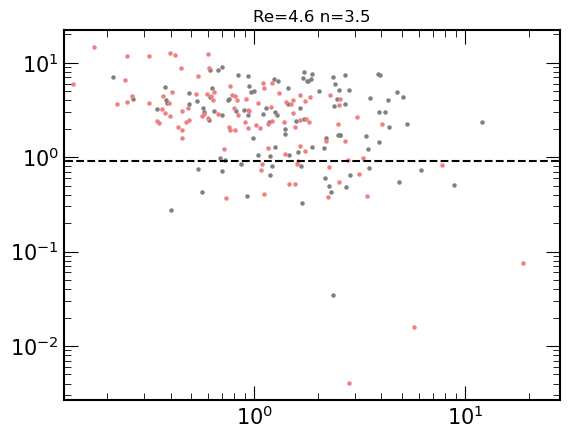

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.405836582183838
3.5 5.1
finished until t = 0.0 0.599647045135498
finished until t = 0.5 4.594974994659424
finished until t = 1.0 12.000318050384521
finished until t = 1.5 22.68668007850647
finished until t = 2.0 36.90734267234802
finished until t = 2.5 54.23765158653259
finished until t = 3.0 74.92820811271667
finished until t = 3.5 99.14269948005676
finished until t = 4.0 126.91438794136047
finished until t = 4.5 158.24352431297302
finished until t = 5.0 191.93120574951172
finished until t = 5.5 225.19256806373596
finished until t = 6.0 261.9638841152191
finished until t = 6.5 302.50968647003174
finished until t = 7.0 346.3346836566925
finished until t = 7.5 394.44138526916504
finished until t = 8.0 446.0834674835205
finished until t = 8.5 499.30500769615173
finished until t = 9.0 556.9661619663239
finished until t = 9.5 616.8044941425323
finished until t = 10.0 679.6340568065643


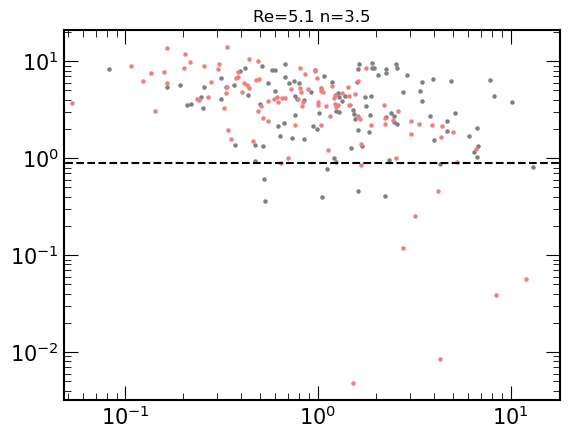

In [3]:
#NFW
R_e_values = [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1]
n_values = [3.5]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             

In [3]:
# NFW ergodic distribution function, calling helpers from NFW_profile_functions.py

######################################
# MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
######################################

rho_0_NFW = 11.82 # 10^5 solar masses / kpc^3
r_0_NFW = 19.54 # kpc
G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
Sersic_params_NFW = [0.9, 1.18]

@np.vectorize
def NFW_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating NFW Energies and Weights')
energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
#E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
print('Finished calculating NFW Energies and Weights')
print(time.time()-start)

# Burkert ergodic distribution function, calling helpers from Burkert_profile_functions.py
rho_0_Burkert = 318.76 # 10^5 solar masses / kpc^3
r_0_Burkert = 3.36 # kpc
Sersic_params_Burkert = [0.9, 1.18]

@np.vectorize
def Burkert_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_Burkert(r, rho_0_Burkert, r_0_Burkert))
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_Burkert(r_psi(psi), rho_0_Burkert, r_0_Burkert, Sersic_params_Burkert[0], Sersic_params_Burkert[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating Burkert Energies and Weights')
energy_values_Burkert = np.pi**2 * G * rho_0_Burkert * r_0_Burkert**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_Burkert = Burkert_ergodic_f(energy_values_Burkert)
#E_dist_Burkert = [energy_values_Burkert, energy_weights_Burkert]
print('Finished calculating Burkert Energies and Weights')
print(time.time()-start)

# making interpolated functions for f(E) that can be called in the initialization process for speed

#def NFW_f_interp(E):
 #   return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

#def Burkert_f_interp(E):
 #
    #return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.29802680015564
Calculating Burkert Energies and Weights
Finished calculating Burkert Energies and Weights
9.881738662719727


In [4]:
# saves outputs for every 0.5 Gyr
#R_e_values = np.arange(1.6, 10.1, 0.5)
n_values = [3.5]
R_e_values = [1.6, 2.1]
#n_values = [1, 4]

def NFW_f_interp(E):
    return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

def Burkert_f_interp(E):
    return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


def run_sim(potential, force, halo_params, ergodic_f, seed, t):
    
    start = time.time()
    
    np.random.seed(seed)
    
    # usual initialization of the sim, units, etc.
    sim = rebound.Simulation()
    sim.ri_ias15.epsilon = 0 # using fixed timesteps
    #sim.ri_ias15.min_dt = 1e-5
    #sim.ri_ias15.max_dt = 1e-3
    sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
    sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
    sim.softening = 0.01 # plummer softening of 10 pc
    sim.collision = "line" # counting collisions as linear interpolations between timesteps
    sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
    # Sersic radial distribution and values to draw positions with their weights
    
    pos_values = np.arange(1e-4, 10, 1e-4)
    pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
    pos_weights /= sum(pos_weights)
    
    # unpacking halo params
    rho_0 = halo_params[0]
    r_0 = halo_params[1]
    
    # setting up a mass function gaussian in logM
    logmass_values = np.linspace(-2, 2, 1000)
    logmass_weights = mass_function(logmass_values)
    logmass_weights /= sum(logmass_weights)
    
    total_GC_mass = 0
    # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
    while total_GC_mass < UGC7369_total_mass-10**(4.987311450993631 - 5):
        mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
        pos_rad = np.random.choice(pos_values, p=pos_weights)
        pos_theta = np.random.uniform(0, np.pi)
        pos_phi = np.random.uniform(0, 2*np.pi)
        x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
        y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
        z_i = pos_rad*np.cos(pos_theta)

        # drawing velocities from provided distribution
        vel_values = np.arange(0.01, 100, 0.01)
        vel_weights = 4*np.pi*vel_values**2 * \
                        ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
        vel_weights /= sum(vel_weights)
        vel_mag = np.random.choice(vel_values, p=vel_weights)
        v_theta = np.random.uniform(0, np.pi)
        v_phi = np.random.uniform(0, 2*np.pi)
        vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
        vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
        vz_i = vel_mag * np.cos(v_theta)
        
        sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
        total_GC_mass += mass/np.exp(10/23)
    
    rebx = reboundx.Extras(sim)
    # adding in the additional forces to work with reboundx
    myforce = rebx.create_force("additional_forces")
    myforce.force_type = "vel"
    myforce.update_accelerations = force
    rebx.add_force(myforce)
    # setting up built-in exponential mass loss
    modifymass = rebx.load_operator("modify_mass")
    rebx.add_operator(modifymass)
    # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
    for p in sim.particles:
        p.params["tau_mass"] = -23
    
    # keeping track of initial positions, velocities, and masses
    initial_masses = []
    initial_positions = []
    initial_vels = []

    for p in sim.particles:
        initial_masses.append(p.m)
        initial_positions.append(np.array([p.x, p.y, p.z]))
        initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    # integrating
    sim.integrate(t)
    
    # keeping track of final positions, velocities, and masses
    final_masses = []
    final_positions = []
    final_vels = []

    for p in sim.particles:
        final_masses.append(p.m)
        final_positions.append(np.array([p.x, p.y, p.z]))
        final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
    initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
    initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
    # clearing sim from memory now that we've stored everything important
    sim = None
    
    # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
    return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]

In [5]:
# run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
    seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
    start = time.time()
    
    for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
        
        if output_time == 0:
            # save initial data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=0.001)
                for GC_n in range(len(masses[0])):
                    f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                            +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                            +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                            +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        else:
            # save final data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=t)
                for GC_n in range(len(masses[1])):
                    f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        print('finished until t = '+str(t), str(time.time()-start))

finished until t = 0.0 1.6871018409729004
finished until t = 0.5 70.75287628173828
finished until t = 1.0 236.98637676239014
finished until t = 1.5 479.6052043437958
finished until t = 2.0 800.7521650791168
finished until t = 2.5 1198.257925271988
finished until t = 3.0 1669.6532425880432
finished until t = 3.5 2216.7730185985565
finished until t = 4.0 2840.3655285835266
finished until t = 4.5 3541.7704560756683
finished until t = 5.0 4318.467489242554
finished until t = 5.5 5171.200970649719
finished until t = 6.0 6105.856596708298
finished until t = 6.5 7112.093015193939
finished until t = 7.0 8185.696116447449
finished until t = 7.5 9328.45226240158
finished until t = 8.0 10551.201093196869
finished until t = 8.5 11849.172093391418
finished until t = 9.0 13208.500514745712
finished until t = 9.5 14648.763247728348
finished until t = 10.0 16164.77830004692


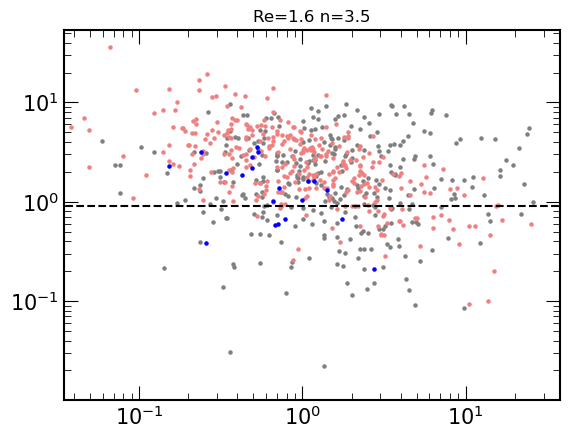

finished until t = 0.0 1.9197804927825928
finished until t = 0.5 89.40615677833557
finished until t = 1.0 259.814959526062
finished until t = 1.5 512.3388261795044
finished until t = 2.0 833.6423296928406
finished until t = 2.5 1209.5088770389557
finished until t = 3.0 1656.9357407093048
finished until t = 3.5 2182.512293100357
finished until t = 4.0 2779.631046772003
finished until t = 4.5 3441.913174390793
finished until t = 5.0 4175.109642744064
finished until t = 5.5 4979.602067947388
finished until t = 6.0 5855.702526330948
finished until t = 6.5 6804.204322576523
finished until t = 7.0 7823.242638349533
finished until t = 7.5 8911.995384454727
finished until t = 8.0 10070.941558361053
finished until t = 8.5 11297.53541970253
finished until t = 9.0 12594.494897127151
finished until t = 9.5 13961.098381280899
finished until t = 10.0 15397.284505844116


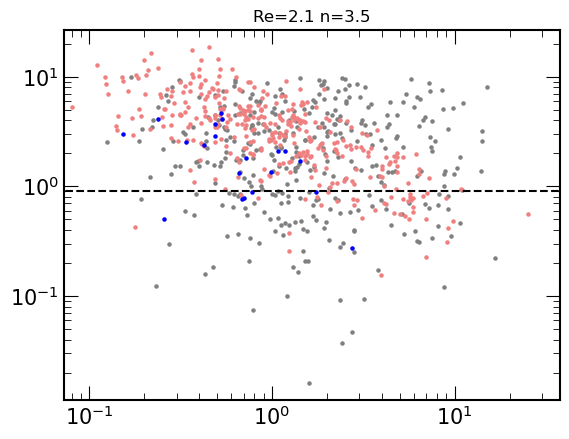

In [6]:
#Burket
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'Burkert-1', phi_Burkert, clib_additional_forces.Burkert_DF_Petts, [318.76, 3.36], Burkert_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('Burkert-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()

finished until t = 0.0 2.031278133392334
finished until t = 0.5 20.414209604263306


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 1.0 53.25651168823242
finished until t = 1.5 104.85745239257812
finished until t = 2.0 169.01121258735657
finished until t = 2.5 243.92205047607422
finished until t = 3.0 335.71307921409607
finished until t = 3.5 449.40708231925964
finished until t = 4.0 580.3106751441956
finished until t = 4.5 723.4650664329529
finished until t = 5.0 878.3182475566864
finished until t = 5.5 1045.5310695171356
finished until t = 6.0 1223.5238718986511
finished until t = 6.5 1412.7552988529205
finished until t = 7.0 1610.1581563949585
finished until t = 7.5 1820.3336424827576
finished until t = 8.0 2040.5226361751556
finished until t = 8.5 2271.7203285694122
finished until t = 9.0 2510.4120185375214
finished until t = 9.5 2758.359789609909
finished until t = 10.0 3017.4152908325195


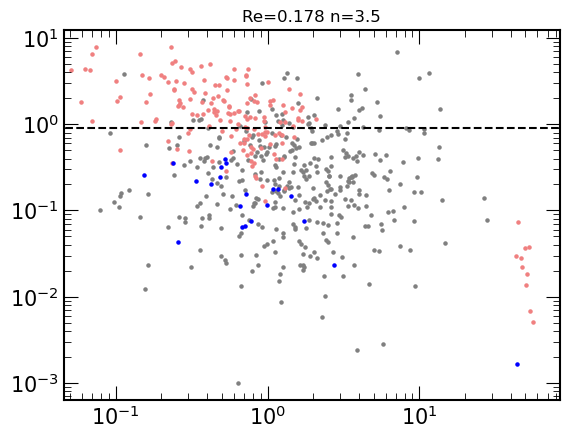

finished until t = 0.0 2.0984363555908203
finished until t = 0.5 31.148158311843872
finished until t = 1.0 83.94837355613708
finished until t = 1.5 153.40071296691895
finished until t = 2.0 242.389750957489
finished until t = 2.5 349.6982843875885
finished until t = 3.0 473.87357091903687
finished until t = 3.5 614.4078702926636
finished until t = 4.0 769.5533440113068
finished until t = 4.5 939.9462776184082
finished until t = 5.0 1125.8726058006287
finished until t = 5.5 1327.1780605316162
finished until t = 6.0 1544.585366010666
finished until t = 6.5 1765.319013118744
finished until t = 7.0 1984.4652259349823
finished until t = 7.5 2204.9992508888245
finished until t = 8.0 2393.2876908779144
finished until t = 8.5 2585.9921748638153
finished until t = 9.0 2785.090322494507
finished until t = 9.5 2992.5858907699585
finished until t = 10.0 3208.626533508301


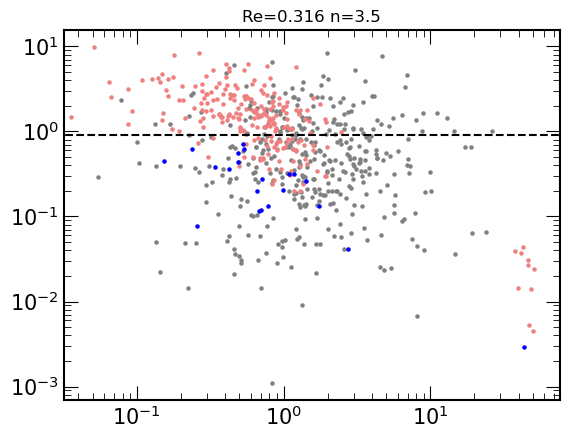

In [10]:
#NFW
R_e_values = [0.178, 0.316]
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        run_iterations(10, 'NFW-1', phi_NFW, clib_additional_forces.NFW_DF_Petts, [11.82, 19.54], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        


        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        